In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import gymnasium as gym


In [12]:
gym.__version__

'0.28.1'

In [ ]:
# Функция для дискретизации пространства состояний
def discrete_space(X, limits: gym.spaces.Box, n=1):
    res = []
    for i, x_n in enumerate(X):
        if n == 0:
            n = 1
        interval = (np.longfloat(limits.high[i]) - np.longfloat(limits.low[i])) / n
        res.append(int((x_n - limits.low[i]) / interval))
    return res


In [14]:
# Функция для выбора действия с учетом epsilon-жадной стратегии
def get_epsilon_greedy_action(Q_state, epsilon, action_n):
    if np.random.rand() < epsilon:
        return np.random.randint(action_n)
    else:
        return np.argmax(Q_state)

In [5]:
# Основная функция Q-learning
def QLearning(env, q_table=None, episode_n=1000, noisy_episode_n=100, n=10, gamma=0.99, t_max=500, alpha=0.5):
    """_summary_

    Args:
        env (Gym.Env): environment to train on.
        q_table (np.array, optional): q_table to train. Defaults to None.
        episode_n (int, optional): Number of episodes to train. Defaults to 1000.
        noisy_episode_n (int, optional): Number of episodes to train with noise. Defaults to 100.
        n (int, optional): Number of bins to discretize the state space. Defaults to 10.
        gamma (float, optional): Discount factor. Defaults to 0.99.
        t_max (int, optional): Maximum number of steps per episode. Defaults to 500.
        alpha (float, optional): Learning rate. Defaults to 0.5.

    Returns:
        np.array: q_table after training.
    """
    state_limits = env.observation_space  # Получаем ограничения пространства состояний
    state_dims = [n] * len(state_limits.high)  # Размеры дискретизированного пространства состояний
    state_limits = env.observation_space  # Получаем ограничения пространства состояний
    state_dims = [n] * len(state_limits.high)  # Размеры дискретизированного пространства состояний
    action_n = env.action_space.n  # Получаем количество действий в среде
    
    if q_table is None:
        Q = np.zeros(state_dims + [action_n])  # Создаем Q-функцию и инициализируем её нулями
    else:
        Q = q_table
    
    epsilon = 1  # Инициализируем действием рандомный шанс
    
    total_rewards = []  # Массив для хранения общих вознаграждений для каждого эпизода
    for episode in tqdm(range(episode_n)):
        epsilon = 1 / (episode + 1)  # Уменьшаем epsilon
        total_reward = 0
        state, _ = env.reset()  # Инициализируем состояние
        discrete_state = tuple(discrete_space(state, state_limits, n))  # Дискретизируем состояние

        for t in range(t_max):
            action = get_epsilon_greedy_action(Q[discrete_state], epsilon, action_n)
            next_state, reward, done, _, _ = env.step(action)
            next_discrete_state = tuple(discrete_space(next_state, state_limits, n))
            
            # Обновляем Q-функцию
            Q[discrete_state][action] += alpha * (reward + gamma * np.max(Q[next_discrete_state]) - Q[discrete_state][action])
            
            total_reward += reward
            if done:
                break
                
            discrete_state = next_discrete_state
            
        epsilon = max(0, epsilon - 1 / noisy_episode_n)
        total_rewards.append(total_reward)
        
    return total_rewards, Q


100%|██████████| 100000/100000 [00:45<00:00, 2211.09it/s]


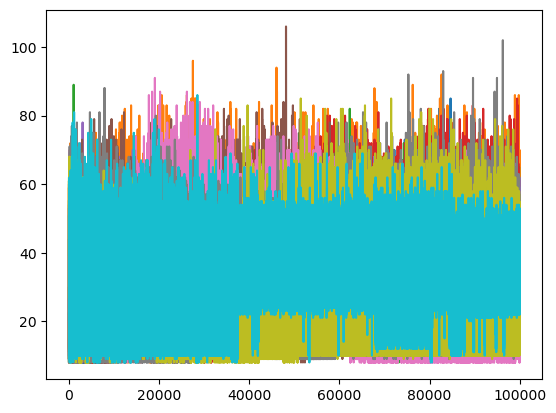

In [ ]:
# Пример использования алгоритма
env = gym.make("CartPole-v1")
q_table = None
for _ in range(10):
    rewards, q_table = QLearning(env, q_table=q_table, episode_n=100000, n=20)
    plt.plot(rewards)
env.close()
# plt.savefig('discrete_CartPole.jpg')
plt.show()